# Nonlinear acoustic isotropic wave-equation operator

In this notebook we show our GPU-based library can be used to easily generate acoustic pressure data. The partial differential equation (PDE) that we will be solving is the following,
\begin{eqnarray}
\left [\mathbf{v}^{-2}(\mathbf{x})\frac{\partial^2}{\partial t^2} - \nabla^2 \right] \mathbf{p}(\mathbf{x},t) = \mathbf{f}(\mathbf{x},t),
\end{eqnarray}
where $\mathbf{v}$ is the subsurface acoustic-wave speed and $\mathbf{p}$ represents the unknown wavefield caused by the source term $\mathbf{f}$. The variables $\mathbf{x}$ and $t$ are the spatial and temporal coordinates, respectively. The source term is often considered to be,
\begin{eqnarray}
\mathbf{f}(\mathbf{x},t) = \mathbf{w}(t)\pmb{\delta}(\mathbf{x}-\mathbf{x}_s),
\end{eqnarray}
where $\mathbf{x}_s$ represent the source position and $\mathbf{w}$ is usually referred to as source wavelet.

## Import modules

In [1]:
# Importing necessary modules
import os
import genericIO
import numpy as np
# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)


## Wavelet

We start this example by generating the source wavelet $\mathbf{w}$, also simply called wavelet.

In [2]:
# Generate wavelet 
!waveletFloatMain.py timeDelay=0.7 f1=2 f2=5 f3=8 f4=15 type=ali par=parNonlinear.p wavelet=results/waveletNonlinear.H

Now let's read and plot the wavelet.

In [3]:
# Reading the wavelet
wavelet = genericIO.defaultIO.getVector("results/waveletNonlinear.H")
waveletNd = wavelet.getNdArray()
waveletHyper = wavelet.getHyper()
nt = waveletHyper.getAxis(1).n
ot = waveletHyper.getAxis(1).o
dt = waveletHyper.getAxis(1).d

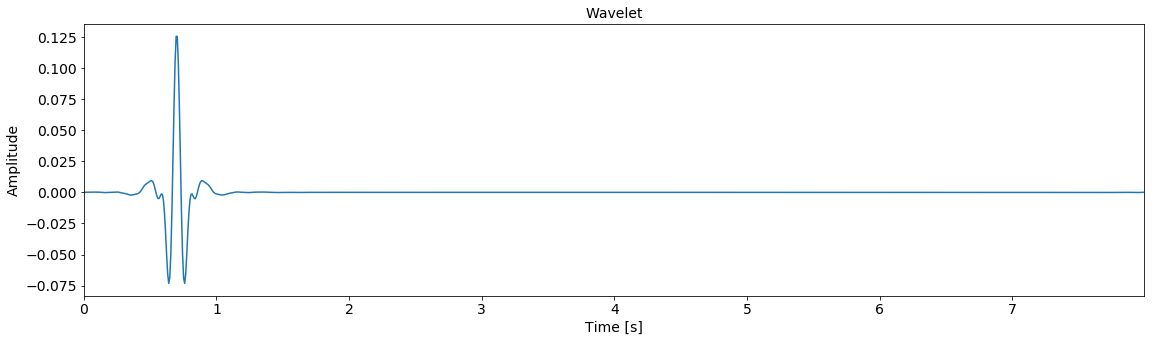

In [4]:
fig,ax=plt.subplots(figsize=(19,5))
time_range = np.linspace(ot,ot+(nt-1)*dt,nt)
plt.plot(np.linspace(ot,ot+(nt-1)*dt,nt), waveletNd)
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

## Marmousi2 P-wave velocity model

In this notebook, we generate data using a 10 m sampled Marmousi2 model (Martin et al., 2006). Let's read the velocity file and plot the velocity function $\mathbf{v}$.

In [5]:
# Reading Marmousi model as a vector
MarmVel = genericIO.defaultIO.getVector("velocityMarmousi.H")
MarmVelNd = MarmVel.getNdArray()
MarmHyper = MarmVel.getHyper()
# Getting axes' information
oz = MarmHyper.getAxis(1).o
dz = MarmHyper.getAxis(1).d
nz = MarmHyper.getAxis(1).n
ox = MarmHyper.getAxis(2).o
dx = MarmHyper.getAxis(2).d
nx = MarmHyper.getAxis(2).n

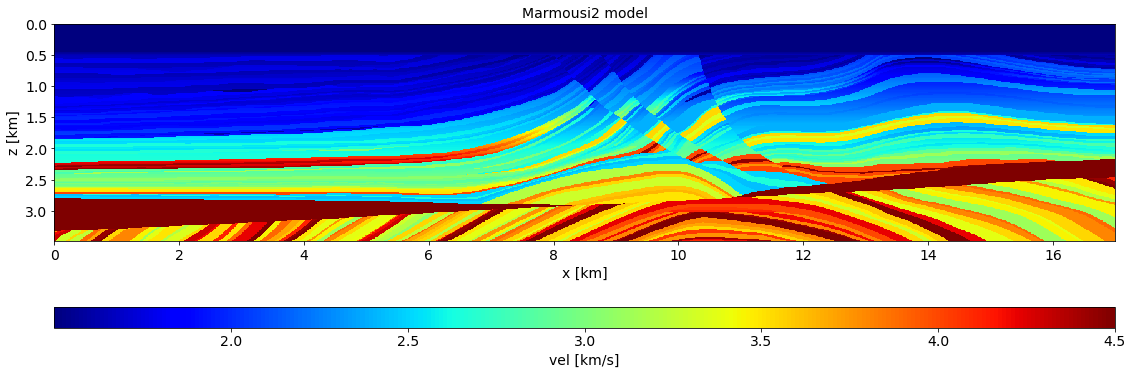

In [6]:
plt.figure(figsize=(19,8))
plt.imshow(MarmVelNd.T,cmap='jet', vmin=MarmVel.min(), vmax=MarmVel.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Marmousi2 model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.show()

Just like any finite-difference modeling code, boundary conditions must be set. In this case, we impose absorbing boundary all around this velocity model. Hence, we pad all the boundaries a buffer absorbing area.

In [7]:
# Pad Marmousi velocity model
!padFileGpuMain zPad=100 xPad=100 model=velocityMarmousi.H data=velocityMarmousi.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Nonlinear modeling for generating shot gathers

Let's now run the modeling script and solve the PDE written above. All the implemented scripts employ a parameter file that contains the necessary information related to the modeling or inversion considered. Let's print the one associated with this example.

In [8]:
# Printing parameter file for reference
!cat parNonlinear.p

nts=1000
dts=0.008
sub=12
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=20
zSource=2
xSource=1
nShot=20
spacingShots=85
depthReceiver=2
nReceiver=1700
dReceiver=1
oReceiver=1
blockSize=16
fat=5
nGpu=4


In [9]:
# Running non-linear operator to generate acoustic data
!nonlinearPythonFloatMain.py info=1 par=parNonlinear.p model=results/waveletNonlinear.H vel=velocityMarmousi.pad.H data=results/nonlinear_data.H

 
-------------------------------------------------------------------
---------------------------- INFO FOR GPU# 0 ----------------------
-------------------------------------------------------------------
Number of requested GPUs: 4
Number of available GPUs: 4
Id of requested GPUs: 0, 1, 2, 3
Cuda driver version: 0
Name: Tesla V100-PCIE-16GB
Total global memory: 15 [GB] 
Shared memory per block: 48 [kB]
Number of register per block: 65536
Warp size: 32 [threads]
Maximum pitch allowed for memory copies in bytes: 1 [GB]
Maximum threads per block: 1024
Maximum block dimensions: (1024, 1024, 64)
Maximum grid dimensions: (2147483647, 65535, 65535)
Total constant memory: 64 [kB]
Number of streaming multiprocessors on device: 80
Device can simultaneously perform a cudaMemcpy() and kernel execution
Device can map host memory
Device can support concurrent kernel
-------------------------------------------------------------------
 
---------------------------------------------------------------

Let's plot three representative shot gathers that have been generated.

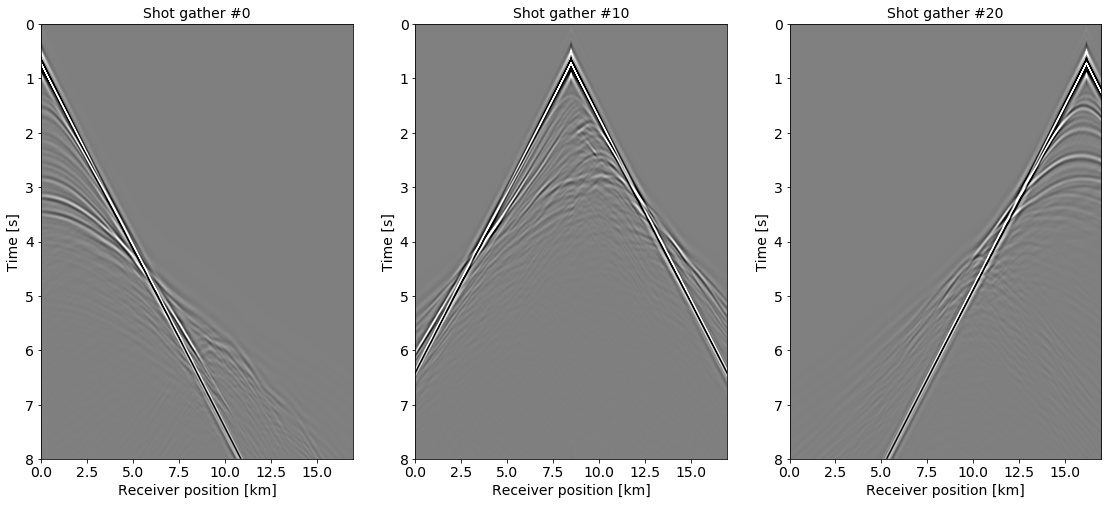

In [10]:
# Plotting the data
dataMarmNd = genericIO.defaultIO.getVector("results/nonlinear_data.H").getNdArray()
clipVal = np.percentile(np.absolute(dataMarmNd[10,:,:]),99.0)

plt.figure(figsize=(19,8))

plt.subplot(131), plt.title("Shot gather #%s"%(0))
plt.imshow(dataMarmNd[0,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.subplot(132), plt.title("Shot gather #%s"%(10))
plt.imshow(dataMarmNd[10,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.subplot(133), plt.title("Shot gather #%s"%(20))
plt.imshow(dataMarmNd[-1,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [km]"), plt.ylabel("Time [s]")

plt.show()

## Dot product test

Lastly, because we are mostly interested in inverse processes, it is crucial to assess the accuracy of the forward mapping against the adjoint operator. We do this using double-precision operators by running the following command:

In [11]:
# Running dot-product test using double-precision numbers
!nonlinearPythonDoubleMain.py par=parNonlinear.p model=results/waveletNonlinear.H vel=velocityMarmousi.pad.H data=results/nonlinear_data.H dpTest=1

Dot-product test of forward and adjoint operators
-------------------------------------------------
Applying forward operator add=False
 Runs in: 7.539547920227051 seconds
Applying adjoint operator add=False
 Runs in: 5.3234851360321045 seconds
Dot products add=False: domain=2.585033e-03 range=2.585033e-03 
Absolute error: 6.071532e-17
Relative error: 2.348725e-14 

Applying forward operator add=True
 Runs in: 6.190887928009033 seconds
Applying adjoint operator add=True
 Runs in: 5.315721035003662 seconds
Dot products add=True: domain=5.170066e-03 range=5.170066e-03 
Absolute error: 1.431147e-16
Relative error: 2.768140e-14 

-------------------------------------------------
